In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
%matplotlib inline
sns.set()
print(os.listdir("../input/turbofan-predictive-maintenance-nasa"))

['train_FD001.txt', 'RUL_FD001.txt', 'test_FD001.txt']


In [2]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
column_names = index_columns_names + op_settings_columns + sensor_columns
print(column_names)

['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']


In [3]:
columns_ = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3', 'Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4', 'Sensor_5', 'Sensor_6', 'Sensor_7', 'Sensor_8', 'Sensor_9', 'Sensor_10', 'Sensor_11', 'Sensor_12', 'Sensor_13', 'Sensor_14', 'Sensor_15', 'Sensor_16', 'Sensor_17', 'Sensor_18', 'Sensor_19', 'Sensor_20', 'Sensor_21']

In [10]:
# load data
train= pd.read_csv('../input/turbofan-predictive-maintenance-nasa/train_FD001.txt', sep=" ", header=None)
test = pd.read_csv('../input/turbofan-predictive-maintenance-nasa/test_FD001.txt', sep=" ", header=None)
print("train shape: ", train.shape, "test shape: ", test.shape)

train shape:  (20631, 28) test shape:  (13096, 28)


In [11]:
train.drop(train.columns[[26, 27]], axis=1, inplace=True)
test.drop(test.columns[[26, 27]], axis=1, inplace=True)
train.columns = columns_
test.columns = columns_

In [12]:
train.head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
# find the last cycle per unit number
max_cycle = train.groupby('UnitNumber')['Cycle'].max().reset_index()
max_cycle.columns = ['UnitNumber', 'MaxOfCycle']

In [14]:
# merge the max cycle back into the original frame
train_merged = train.merge(max_cycle, left_on='UnitNumber', right_on='UnitNumber', how='inner')

In [15]:
# calculate RUL for each row
Target_Remaining_Useful_Life = train_merged["MaxOfCycle"] - train_merged["Cycle"]
train_with_target = train_merged["Target_Remaining_Useful_Life"] = Target_Remaining_Useful_Life

In [16]:
# remove unnecessary column
train_with_target = train_merged.drop("MaxOfCycle", axis=1)
train_with_target[train_with_target['UnitNumber'] == 1].head(5)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Target_Remaining_Useful_Life
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [17]:
# now it's time to clear out target leakage
print(train_with_target.shape)
leakage_to_drop = ['UnitNumber', 'Cycle', 'Op_Setting_1', 'Op_Setting_2', 'Op_Setting_3']  
train_no_leakage = train_with_target.drop(leakage_to_drop, axis = 1)
print(train_no_leakage.shape)
# set up features and target variable 
y = train_no_leakage['Target_Remaining_Useful_Life']
X = train_no_leakage.drop(['Target_Remaining_Useful_Life'], axis = 1)

(20631, 27)
(20631, 22)


In [18]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 200, max_depth = 15)
single_rf.fit(X, y)
y_pred = single_rf.predict(X)
print("complete")

complete


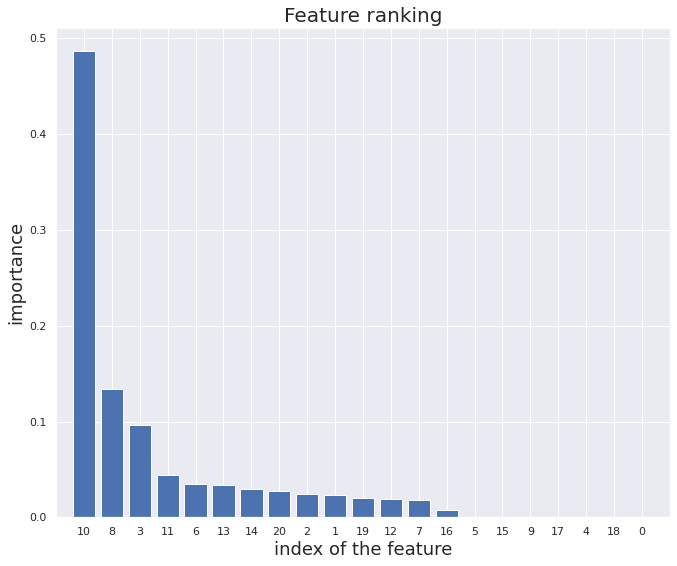

In [19]:
# graph feature importance
import matplotlib.pyplot as plt
importances = single_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X.shape[1]), indices) #feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

In [20]:
# list feature importance
important_features = pd.Series(data=single_rf.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features.head(10))

Sensor_11    0.486380
Sensor_9     0.133873
Sensor_4     0.095912
Sensor_12    0.043955
Sensor_7     0.034258
Sensor_14    0.034170
Sensor_15    0.029570
Sensor_21    0.027879
Sensor_3     0.024769
Sensor_2     0.023797
dtype: float64


In [21]:
# based on the graphs as well as random forest feature importance, I will exclude sensors without much valuable information
print(train_no_leakage.shape)
vars_to_drop = ["Sensor_"+str(i) for i in [5, 15, 9, 17, 4, 18]]
train_final = train_no_leakage.drop(vars_to_drop, axis = 1)
print(train_final.shape)

(20631, 22)
(20631, 16)


In [22]:
# identify categorical and numeric fields
from sklearn import preprocessing
categorical = train_final.select_dtypes(include=['object'])
numeric = train_final.select_dtypes(exclude=['object'])
print(categorical.columns.values)
# create dummy variables (if any categorical fields)
for name, values in categorical.items():
    print(name)
    dummies = pd.get_dummies(values.str.strip(), prefix = name, dummy_na=True)
    numeric = pd.concat([numeric, dummies], axis=1)

[]


In [23]:
# imputation (if any NULL values)
for name in numeric:
    print(name)
    if pd.isnull(numeric[name]).sum() > 0:
        numeric["%s_mi" % (name)] = pd.isnull(numeric[name])
        median = numeric[name].median()
        numeric[name] = numeric[name].apply(lambda x: median if pd.isnull(x) else x)
y = numeric['Target_Remaining_Useful_Life']
X = numeric.drop(['Target_Remaining_Useful_Life'], axis = 1)

Sensor_1
Sensor_2
Sensor_3
Sensor_6
Sensor_7
Sensor_8
Sensor_10
Sensor_11
Sensor_12
Sensor_13
Sensor_14
Sensor_16
Sensor_19
Sensor_20
Sensor_21
Target_Remaining_Useful_Life


In [24]:
# random forest regression
# create holdout
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# choose the model
from sklearn.ensemble import RandomForestRegressor
rf = ensemble.RandomForestRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)

In [25]:
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])

In [26]:
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]

In [27]:
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [7, 8, 9, 10, 11, 12],
                         'model__min_samples_leaf': [2, 10, 25, 50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
# show the best model estimators
print(optimized_rf.best_estimator_)

Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=11, min_samples_leaf=10))])


In [29]:
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_rf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Random Forest Mean Squared Error:  1764.4355240567322
Random Forest Mean Absolute Error:  29.796092889447994
Random Forest r-squared:  0.6266676837626247


In [32]:
from joblib import dump, load
dump(optimized_rf, 'forest_model.joblib')

['forest_model.joblib']

In [33]:
clf = load('forest_model.joblib')

In [34]:
y_pred = clf.predict(X_test)
print("Random Forest Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Random Forest Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Random Forest r-squared: ", r2_score(y_test, y_pred))

Random Forest Mean Squared Error:  1764.4355240567322
Random Forest Mean Absolute Error:  29.796092889447994
Random Forest r-squared:  0.6266676837626247


In [35]:
X_test.iloc[1,:].values

array([5.18670e+02, 6.43200e+02, 1.59164e+03, 2.16100e+01, 5.52210e+02,
       2.38819e+03, 1.30000e+00, 4.77400e+01, 5.20480e+02, 2.38815e+03,
       8.13726e+03, 3.00000e-02, 1.00000e+02, 3.87000e+01, 2.31894e+01])

In [36]:
test_data = [5.18670e+02, 6.43200e+02, 1.59164e+03, 2.16100e+01, 5.52210e+02,
       2.38819e+03, 1.30000e+00, 4.77400e+01, 5.20480e+02, 2.38815e+03,
       8.13726e+03, 3.00000e-02, 1.00000e+02, 3.87000e+01, 2.31894e+01]

In [38]:
clf.predict([test_data])

array([44.5549735])